In [3]:
import pandas as pd
import logging

In [4]:
def split_csv(input_file, rows_per_file, output_prefix):
    # Read the CSV file
    try:
        data = pd.read_csv(input_file)
        print(f"Successfully read {input_file}")
    except Exception as e:
        print(f"Error reading {input_file}: {e}")
    # Determine number of splits needed
    total_rows = data.shape[0]
    total_splits = (total_rows + rows_per_file - 1) // rows_per_file
    logging.info(f"Total rows in file: {total_rows}. Rows per split: {rows_per_file}. Total splits needed: {total_splits}")
    # Split the file and write to new CSV files
    for i in range(total_splits):
        start_row = i * rows_per_file
        end_row = min(start_row + rows_per_file, total_rows)
        output_file = f"{output_prefix}_{i+1}.csv"

        # Save the slice of the dataframe to a new CSV file
        data[start_row:end_row].to_csv(output_file, index=False)
        logging.info(f"Written {output_file} with rows {start_row+1} to {end_row}")

### Loading the dataset

In [5]:
df = pd.read_csv("data/news_category_classification/bbc-text.csv")
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


[Text(0.5, 1.0, 'Count of different types of news articles')]

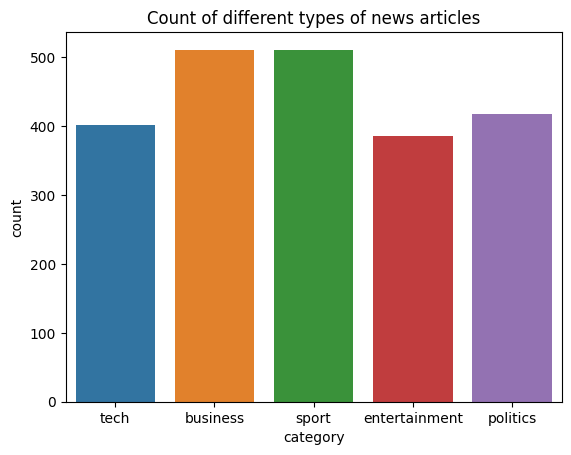

In [8]:
import seaborn as sns
#Countplot of different types of Articles in the dataset
sns.countplot(x=df['category'],hue=df['category']).set(title='Count of different types of news articles')


In [60]:
# Checking the number of categories and if the imbalance of the dataset is severe
df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

### Preparation for Few Shot Examples

Selecting 2 examples from each category for the few shot examples.

In [61]:
df.sample(n=10, random_state=42)

,category,text
414,politics,brown and blair face new rift claims for the u...
420,business,small firms hit by rising costs rising fuel ...
1644,entertainment,spirit awards hail sideways the comedy sideway...
416,tech,microsoft releases patches microsoft has warne...
1232,sport,arsenal through on penalties arsenal win 4-2 o...
1544,business,jobs go at oracle after takeover oracle has an...
1748,business,id theft surge hits us consumers almost a quar...
1264,sport,poll explains free-kick decision referee graha...
629,sport,parmar ruled out of davis cup tie a knee injur...
1043,tech,video phones act as dating tools technologies ...


In [63]:
index_locs_to_be_filtered = [414, 591, 420, 396, 1912, 1461, 1056, 1019, 416, 1214]

In [64]:
few_shot_examples_df = df.iloc[index_locs_to_be_filtered]
few_shot_examples_df.reset_index(drop=True, inplace=True)

In [65]:
few_shot_examples_df

,category,text
0,politics,brown and blair face new rift claims for the u...
1,politics,david blunkett in quotes david blunkett - who ...
2,business,small firms hit by rising costs rising fuel ...
3,business,tsunami to hit sri lanka banks sri lanka s b...
4,entertainment,elvis fans hold birthday bash elvis fans aroun...
5,entertainment,singer ian brown in gig arrest former stone ...
6,sport,wenger steps up row arsene wenger has stepped ...
7,sport,boro suffer morrison injury blow middlesbrough...
8,tech,microsoft releases patches microsoft has warne...
9,tech,toxic web links help virus spread virus writer...


In [66]:
user_prompt_template = f"""Examples on how the news article as input text is classified:
```
Input: {few_shot_examples_df['text'][1]}
Output: {few_shot_examples_df['category'][1]}

Input: {few_shot_examples_df['text'][2]}
Output: {few_shot_examples_df['category'][2]}

Input: {few_shot_examples_df['text'][4]}
Output: {few_shot_examples_df['category'][4]}

Input: {few_shot_examples_df['text'][6]}
Output: {few_shot_examples_df['category'][6]}

Input: {few_shot_examples_df['text'][8]}
Output: {few_shot_examples_df['category'][8]}
```

Now, classify the following text. Respond with one word from the five categories: Sport, Tech, Business, Entertainment, or Politics.:

Input: {{text_to_be_classified}}
Output:
"""

In [67]:
with open("data/news_category_classification/user_prompt_template2.txt", "w") as f:
    f.write(user_prompt_template)

### Preparation for Text Examples

For fair evaluation, we will exclude out the few-shot examples from the dataset. And then only proceed with selecting test examples.

In [68]:
new_df = df.drop(index=index_locs_to_be_filtered)
new_df.reset_index(drop=True, inplace=True)
new_df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2210,business,cars pull down us retail figures us retail sal...
2211,politics,kilroy unveils immigration policy ex-chatshow ...
2212,entertainment,rem announce new glasgow concert us band rem h...
2213,politics,how political squabbles snowball it s become c...


In [69]:
new_df.sample(n=500, random_state=42)['category'].value_counts()

business         118
sport            108
politics         100
entertainment     88
tech              86
Name: category, dtype: int64

In [70]:
text_examples = new_df.sample(n=500, random_state=42)
text_examples.reset_index(drop=True, inplace=True)

In [73]:
text_examples.to_csv("data/news_category_classification/test-examples.csv", index=False)

Splitting the single CSV file into multiple CSV files with 50 rows

In [72]:
split_csv('data/news_category_classification/test-examples.csv', 50, 'data/news_category_classification/test-examples')

2024-05-25 22:40:21,934 - INFO - Total rows in file: 500. Rows per split: 50. Total splits needed: 10
2024-05-25 22:40:21,944 - INFO - Written data/news_category_classification/test-examples_1.csv with rows 1 to 50
2024-05-25 22:40:21,950 - INFO - Written data/news_category_classification/test-examples_2.csv with rows 51 to 100
2024-05-25 22:40:21,955 - INFO - Written data/news_category_classification/test-examples_3.csv with rows 101 to 150
2024-05-25 22:40:21,961 - INFO - Written data/news_category_classification/test-examples_4.csv with rows 151 to 200
2024-05-25 22:40:21,971 - INFO - Written data/news_category_classification/test-examples_5.csv with rows 201 to 250


2024-05-25 22:40:21,981 - INFO - Written data/news_category_classification/test-examples_6.csv with rows 251 to 300
2024-05-25 22:40:21,988 - INFO - Written data/news_category_classification/test-examples_7.csv with rows 301 to 350
2024-05-25 22:40:21,998 - INFO - Written data/news_category_classification/test-examples_8.csv with rows 351 to 400
2024-05-25 22:40:22,005 - INFO - Written data/news_category_classification/test-examples_9.csv with rows 401 to 450
2024-05-25 22:40:22,014 - INFO - Written data/news_category_classification/test-examples_10.csv with rows 451 to 500


Successfully read data/news_category_classification/test-examples.csv
